In [1]:
# Imports
import os

# import methods from FIA python script
from FIA import *

oms.LogConfigHandler().setLogLevel("DEBUG")

## Loading

In [2]:
# set path to your mzML files and workfolder
data_dir = "../../data/example data/exampleA_ecolistrains"
run_dir = "../../runs/fia_explorer"

data_dir = os.path.normpath(os.path.join(os.getcwd(), data_dir))
run_dir = os.path.normpath(os.path.join(os.getcwd(), run_dir))

# clean_dir(run_dir)

In [3]:
fia_df = load_fia_df(data_dir, ".mzXML")

Loading experiments:
Loading names:


## Initial Centroiding

#### TOF Parameters


In [4]:
fia_df["cent_experiment"] = fia_df["experiment"].apply(lambda experiment: centroid_experiment(experiment, instrument="TOF",
                                                                                                signal_to_noise=2.0, spacing_difference=1.5,
                                                                                                peak_width=0.0, sn_bin_count=100, nr_iterations=5, sn_win_len=20.0,
                                                                                                check_width_internally="false", ms1_only="true", clear_meta_data="false",
                                                                                                deepcopy=False))

## Data pruning & binning

In [5]:
# Computes mean, media or sum of binned peaks (median needs ~2* more time)
fia_df["bin_experiment"] = fia_df["experiment"].apply(lambda experiment: limit_experiment(experiment, 51, 1699, 2*10**6, statistic="sum", deepcopy=True))

## Summing intensities

In [6]:
fia_df["sum_spectra"] = fia_df["bin_experiment"].apply(lambda experiment: sum_spectra(experiment)) # type: ignore

## Combining

In [7]:
comb_df = pd.DataFrame(columns=["polarity", "comb_experiment"])
for polarity in fia_df["polarity"].unique():
    comb_df.loc[len(comb_df.index)] = [polarity, combine_spectra_experiments(fia_df.loc[fia_df["polarity"] == polarity]["sum_spectra"].to_list())]

## Clustering

In [16]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import single, fcluster, complete, complete, dendrogram, linkage
from scipy.stats import linregress
from scipy.signal import find_peaks

In [23]:
clust_df = comb_df.loc[0, "comb_experiment"].get_df(long=True)
clust_df = clust_df.sort_values("mz", ignore_index=True)

,RT,mz,inty
0,0.0,51.000412,1008.232239
1,2.0,51.000412,795.877197
2,1.0,51.000412,1075.246948
3,0.0,51.001236,506.346375
4,2.0,51.001236,1007.001831
...,...,...,...
5999995,0.0,1698.998779,358.689117
5999996,1.0,1698.998779,0.000000
5999997,1.0,1698.999634,0.000000
5999998,0.0,1698.999634,482.200226


### Matlab

In [17]:
peaks, properties = find_peaks(clust_df["inty"], height=1000, prominence=1000)

In [20]:
peaked_df = clust_df.loc[peaks]
peaked_df

,RT,mz,inty
9,0.0,51.007828,1057.709961
16,0.0,51.013596,753.372375
25,0.0,51.021011,2363.740723
35,0.0,51.029251,1828.474121
55,0.0,51.045731,1395.235229
...,...,...,...
5999969,2.0,1698.974854,137.007584
5999978,2.0,1698.982300,758.442078
5999983,2.0,1698.986450,0.000000
5999988,2.0,1698.990479,514.423828


In [11]:
ulim = 20000
llim = 0
xdim = -1
ydim = 1

# @(x,y) (x(:,1)-y(:,1)).^2  + (x(:,2)==y(:,2))*10^6; 
distances = pdist(clust_df["mz"].values[llim:ulim].reshape(xdim,ydim), metric="cityblock")**2 + pdist(clust_df["RT"].values[llim:ulim].reshape(xdim,ydim), metric="hamming")*1e6

In [12]:
tree = linkage(distances, method="complete")
# t = threshold
cluster = fcluster(tree, t=7e-2 **2, criterion="distance")
cluster = np.repeat(cluster, ydim)
len(np.unique(cluster))

396

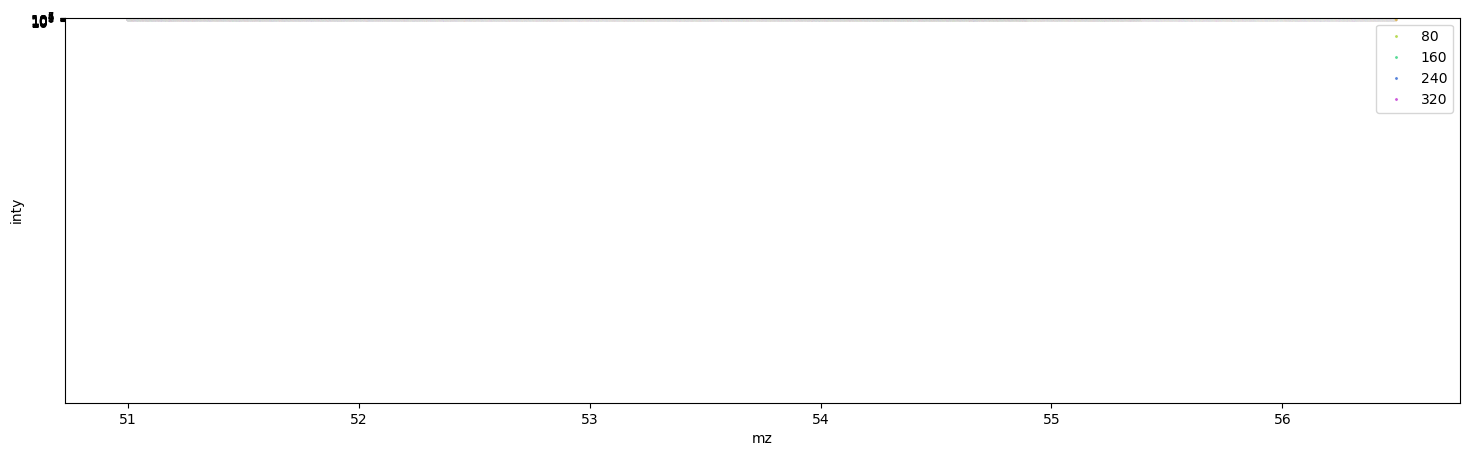

In [13]:
sns_plot(clust_df["mz"][llim:ulim], clust_df["inty"][llim:ulim], hue=cluster, size=cluster,
         xlim=None, ylim=[0, 1e8],plottype="scatter", log=["y"], sizes=(5, 5), palette="hls")   # distinct: tab10, continous: hls

In [14]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

## Try

In [ ]:
mz_int_paired = np.stack([clust_df["mz"], clust_df["inty"]], axis=-1)

In [ ]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

### Sklearn

In [ ]:
from sklearn.cluster import *
import math

In [ ]:
methods = []
methods.append(HDBSCAN(min_cluster_size=100, min_samples=10, cluster_selection_epsilon=0.0, max_cluster_size=None, metric='euclidean',
                       metric_params=None, alpha=1.0, algorithm='auto', leaf_size=20, n_jobs=None, cluster_selection_method='leaf', 
                       allow_single_cluster=False, store_centers=None, copy=False)
                )

clusters = [method.fit(clust_df.loc[0:12000]) for method in tqdm(methods)]


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


(100.0, 100000000.0)

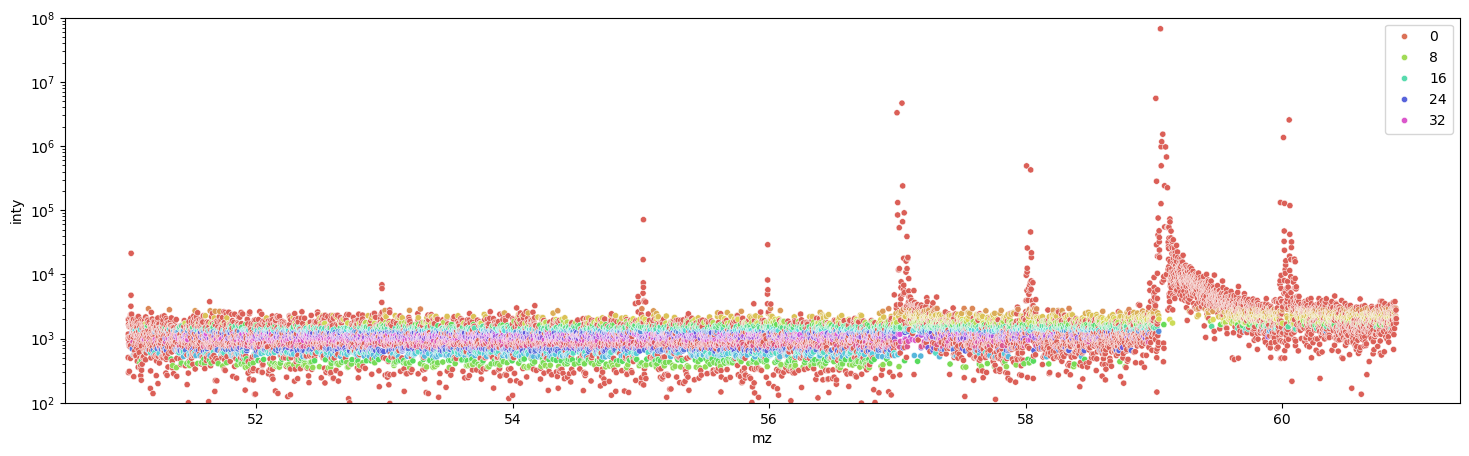

In [ ]:
plt.figure(figsize = (18, 5))
cluster = clusters[0]
sns.scatterplot(x=clust_df["mz"][0:12001], y=clust_df["inty"][0:12001], hue=cluster.labels_, size=cluster.labels_, sizes=(20, 20), palette="hls")
plt.yscale('log')
plt.ylim([1e2, 1e8])

### Scipy

(100.0, 100000000.0)

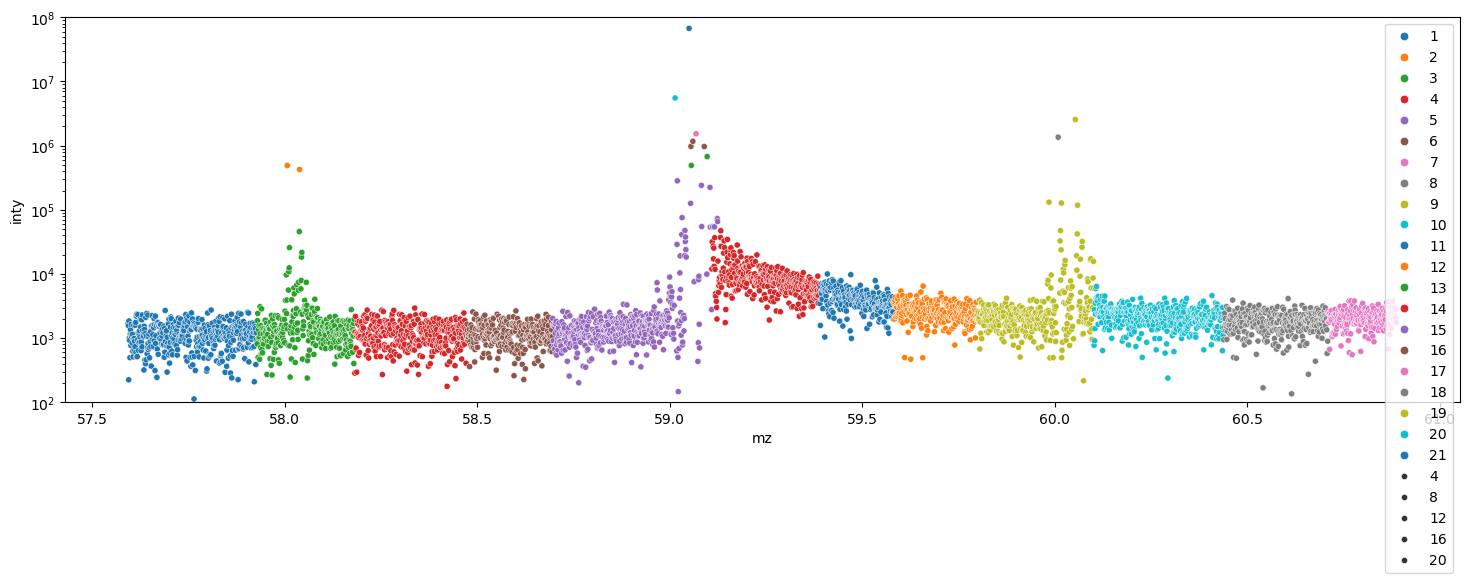

In [ ]:
distances = pdist(mz_int_paired[8000:12000], metric="mahalanobis")
tree = linkage(distances, method="complete")
# t = threshold
cluster = fcluster(tree, t=0.4, criterion="distance")

# continous palette: hls, distinct palette: tab10
plt.figure(figsize = (18, 5))
sns.scatterplot(x=clust_df["mz"][8000:12000], y=clust_df["inty"][8000:12000], hue=cluster, size=cluster, sizes=(20, 20), palette="tab10")
plt.yscale('log')
plt.ylim([1e2, 1e8])

### Own function

In [ ]:
np.mean(clust_df["inty"]) # Use mean / median deviation ? <- significant difference ! 

1661.8009

In [ ]:
ulim = 20000
llim = 0
xdim = -1
ydim = 100

distances = pdist(clust_df["mz"].values[llim:ulim].reshape(xdim,ydim), metric="cityblock") / (
    np.tanh(pdist(clust_df["inty"].values[llim:ulim].reshape(xdim,ydim), metric='cityblock') + 1)+ 1)

In [ ]:
tree = linkage(distances, method="complete")
# t = threshold
cluster = fcluster(tree, t=7e1, criterion="distance")
cluster = np.repeat(cluster, ydim)
len(np.unique(cluster))

17

C:\Users\JosuaCarl\AppData\Local\Temp\ipykernel_12156\1525462530.py:5: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([0, 1e8])


(6.14872499974188, 100000000.0)

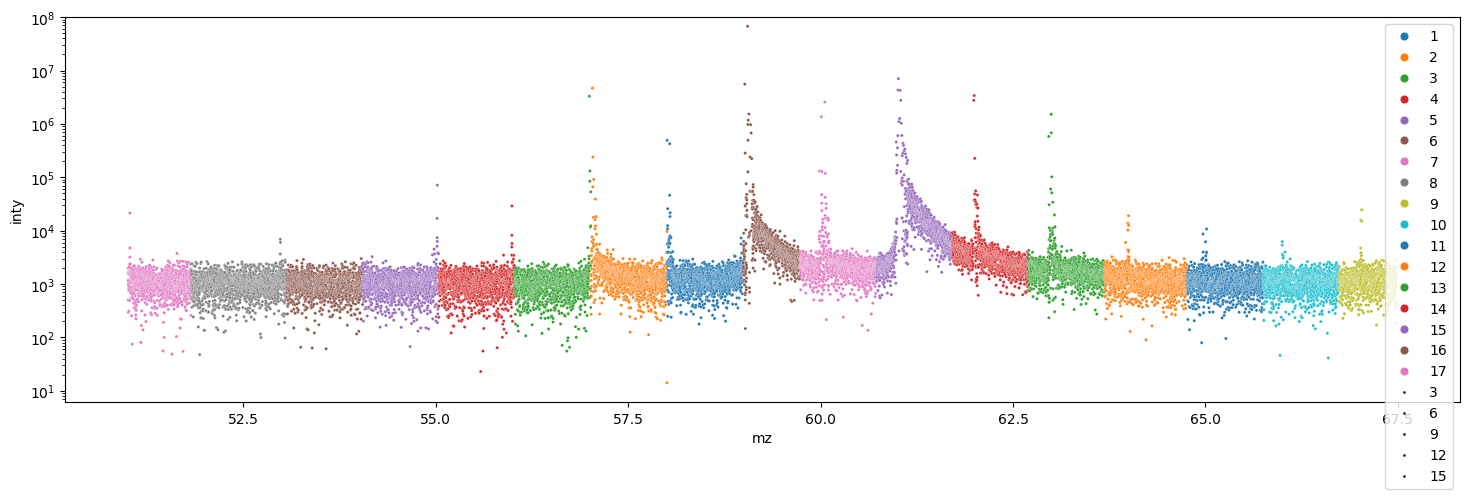

In [ ]:
# continous palette: hls, distinct palette: tab10
plt.figure(figsize = (18, 5))
sns.scatterplot(x=clust_df["mz"][llim:ulim], y=clust_df["inty"][llim:ulim], hue=cluster, size=cluster, sizes=(5, 5), palette="tab10")
plt.yscale('log')
plt.ylim([0, 1e8])

### Sequential clustering

In [ ]:
def cluster_run(arr, win, thresh):
    cluster = 1
    clusters = [cluster]*win
    for i in tqdm(range(win, len(arr)- win)):
        upw, u, *_ = linregress(arr[i-win:i])
        dnw, d, *_ = linregress(arr[i:i+win])
        if abs(upw) > thresh or abs(dnw) > thresh:
            cluster += 1
        clusters.append(cluster)
    clusters += [cluster]*win
    return clusters

In [ ]:
cluster = cluster_run(mz_int_paired[0:20000], 200, 4.5e7)
len(np.unique(cluster))

100%|██████████| 19600/19600 [00:01<00:00, 10807.81it/s]


25

C:\Users\JosuaCarl\AppData\Local\Temp\ipykernel_12156\1525462530.py:5: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([0, 1e8])


(6.14872499974188, 100000000.0)

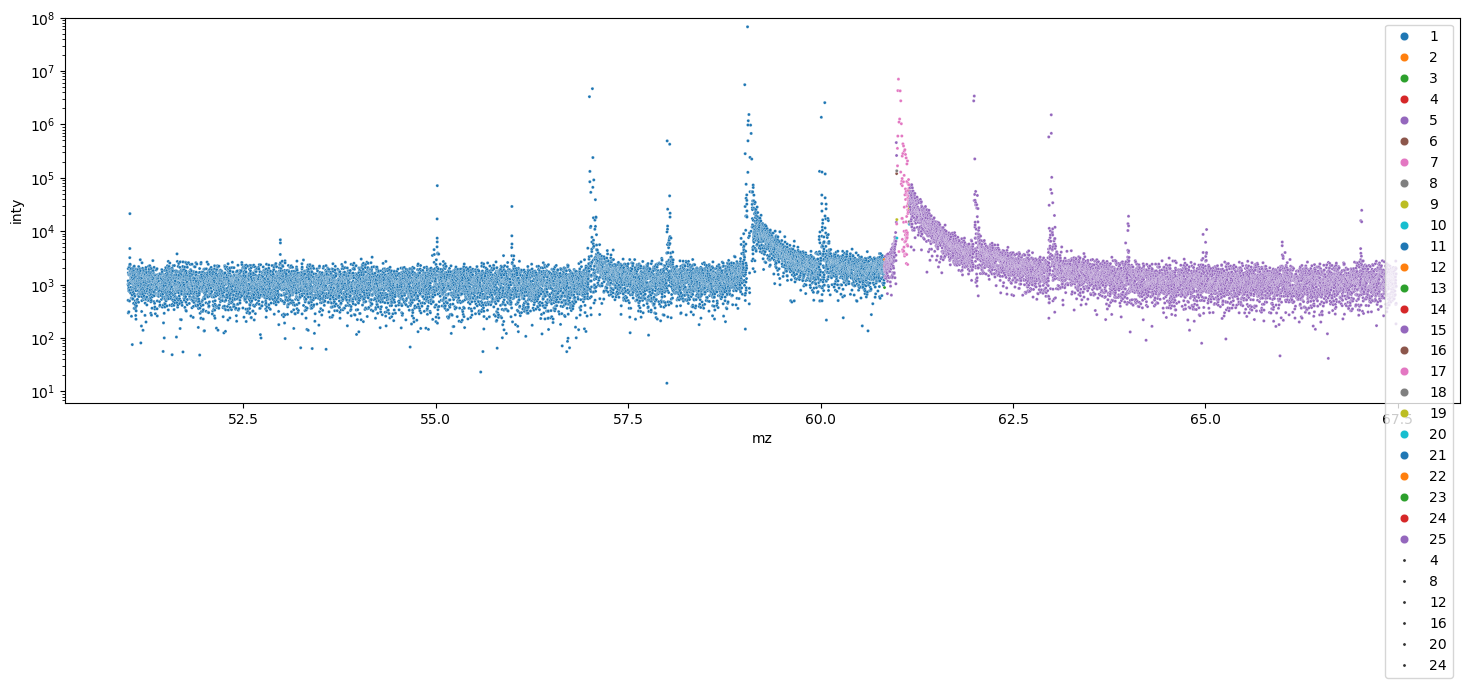

In [ ]:
# continous palette: hls, distinct palette: tab10
plt.figure(figsize = (18, 5))
sns.scatterplot(x=clust_df["mz"][llim:ulim], y=clust_df["inty"][llim:ulim], hue=cluster, size=cluster, sizes=(5, 5), palette="tab10")
plt.yscale('log')
plt.ylim([0, 1e8])